In [1]:
import numpy as np

quizzes = np.zeros((1000000, 81), np.int32)
solutions = np.zeros((1000000, 81), np.int32)
for i, line in enumerate(open('sudoku.csv', 'r').read().splitlines()[1:]):
    quiz, solution = line.split(",")
    for j, q_s in enumerate(zip(quiz, solution)):
        q, s = q_s
        quizzes[i, j] = q
        solutions[i, j] = s
quizzes = quizzes.reshape((-1, 9, 9))
solutions = solutions.reshape((-1, 9, 9))

In [2]:
print('Quiz:')
print(quizzes[0])
print('Solution:')
print(solutions[0])

Quiz:
[[0 0 4 3 0 0 2 0 9]
 [0 0 5 0 0 9 0 0 1]
 [0 7 0 0 6 0 0 4 3]
 [0 0 6 0 0 2 0 8 7]
 [1 9 0 0 0 7 4 0 0]
 [0 5 0 0 8 3 0 0 0]
 [6 0 0 0 0 0 1 0 5]
 [0 0 3 5 0 8 6 9 0]
 [0 4 2 9 1 0 3 0 0]]
Solution:
[[8 6 4 3 7 1 2 5 9]
 [3 2 5 8 4 9 7 6 1]
 [9 7 1 2 6 5 8 4 3]
 [4 3 6 1 9 2 5 8 7]
 [1 9 8 6 5 7 4 3 2]
 [2 5 7 4 8 3 9 1 6]
 [6 8 9 7 3 4 1 2 5]
 [7 1 3 5 2 8 6 9 4]
 [5 4 2 9 1 6 3 7 8]]


Using backend: pytorch


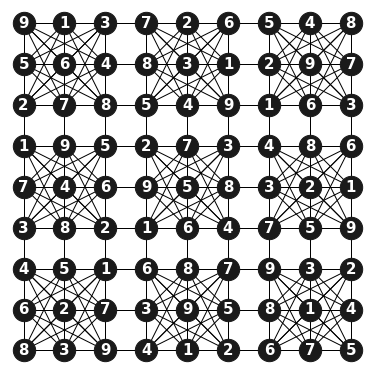

In [3]:
import torch
import dgl
import networkx as nx
import matplotlib.pyplot as plt

def index_2_node(i, j):
    """
    Input: integers i,j between 0 and 8, corresponding to the index of the 9x9 sudoku array
    Output: node between 0 and 80, corresponding to the index of the flattened array
    """
    node = 9*i + j
    return node

def node_2_index(node):
    """
    Input: node between 0 and 80, corresponding to the index of the flattened array
    Output: integers i,j between 0 and 8, corresponding to the index of the 9x9 sudoku array
    """
    i, j = node // 9, node % 9
    return i, j

edges = []
for node_source in range(81):
    for node_dest in range(81):
        i_source, j_source = node_2_index(node_source)
        i_dest, j_dest = node_2_index(node_dest)
        
        if node_source != node_dest:
            if i_source == i_dest \
            or j_source == j_dest \
            or (i_source // 3 == i_dest // 3) and (j_source // 3 == j_dest // 3):
                edges.append((node_source, node_dest))

base_graph = dgl.graph(edges)

nx_G = dgl.to_homogeneous(base_graph).to_networkx().to_undirected()
pos = {node: node_2_index(node) for node in range(81)}
labels = {i:j for i, j in enumerate(solutions[0].flatten())}
plt.figure(figsize=(5, 5)) 
nx.draw(nx_G, pos, node_size=500, node_color=[[0.1, 0.1, 0.1]], 
        labels=labels, with_labels=True, font_color='w', font_weight='heavy', font_size=15)

In [11]:
import torch.nn as nn
import dgl.nn.pytorch as dglnn

class RRN_Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = nn.LeakyReLU()
        self.hdim = 100
        self.num_heads = 3
        
        self.lin_m1 = nn.Linear(self.hdim, self.hdim)
        
        self.conv1 = dglnn.GATConv(self.hdim, self.hdim, self.num_heads, activation=self.relu)
        
        self.lin_hd1 = nn.Linear(self.num_heads*self.hdim + self.hdim + 10, self.hdim)
      
        self.lin_y2 = nn.Linear(self.hdim, 9)
        
    def forward(self, g, x, h):
        # prepare message
        m = self.lin_m1(h)
        m = self.relu(m)
        
        # aggregate messages
        m = self.conv1(g, m)
        m = m.view(x.shape[0], -1)

        # create hidden state
        h = self.lin_hd1(torch.cat((h, x, m), dim=1))
        h = self.relu(h)
        
        # create output
        y = self.lin_y2(h)
        
        return y, h

In [15]:
from torch.utils.data import Dataset
import copy

def sudoku_2_onehot(sudoku):
    """
    Input: 9x9 sudoku array
    Output: 9x9x10 array 'onehot', where onehot[i, j, :] is a onehot-vector for sudoku[i, j]
    """
    onehot = np.zeros((9, 9, 10))
    for i in range(9):
        for j in range(9):
            if sudoku[i, j] > 0:
                onehot[i, j, sudoku[i, j] - 1] = 1
            else:
                onehot[i, j, -1] = 1
    return onehot

def sudoku_2_graph(sudoku):
    onehot = sudoku_2_onehot(sudoku)
    g = copy.deepcopy(base_graph)
    g.ndata['onehot'] = torch.tensor(onehot.reshape((81, 10)), dtype=torch.float)
    return g

def sudoku_2_solution(sudoku):
    solution = torch.tensor([i-1 for i in sudoku.reshape(81)], dtype=torch.long)
    return solution

class SudokuGraphDataset(Dataset):
    
    def __init__(self, quizzes, solutions):
        self.quizzes = quizzes
        self.solutions = solutions

    def __len__(self):
        return len(self.quizzes)

    def __getitem__(self, idx):
        g = sudoku_2_graph(self.quizzes[idx])
        solution = sudoku_2_solution(self.solutions[idx])
        return (g, solution)
    
dataset = SudokuGraphDataset(quizzes, solutions)
data_loader = dgl.dataloading.GraphDataLoader(dataset, batch_size=100, shuffle=True)

In [6]:
def train(model):
    loss_func = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for iter, (g, solution) in enumerate(data_loader):
        """MESSAGE HERE"""
        loss = 0
        h = torch.zeros((g.ndata['onehot'].shape[0], model.hdim)) # hidden layer initialised with 0s
        for _ in range(30): # model is applied recurrently 30 times
            prediction, h = model(g, g.ndata['onehot'], h)
            loss += loss_func(prediction, solution.flatten()) / 30 # loss is accumulated to aid convergence
        final_loss = loss_func(prediction, solution.flatten()) # the loss of the final prediction gives an idea of how the full model will perform
        print(loss.item(), final_loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1) # clip gradient
        optimizer.step()

In [16]:
#model = RRN_Model()
train(model)

2.198640823364258 2.1986207962036133
2.1951475143432617 2.1951024532318115
2.192100763320923 2.192045211791992
2.189354181289673 2.1892740726470947
2.1866838932037354 2.1865830421447754
2.183929204940796 2.183790922164917


KeyboardInterrupt: 

In [7]:
# load the pretrained model
model = RRN_Model()
model.load_state_dict(torch.load('./model.pt'))

FileNotFoundError: [Errno 2] No such file or directory: './model.pt'

In [10]:
import random

def solve_sudoku(sudoku):
    g = sudoku_2_graph(sudoku)
    h = torch.zeros((g.ndata['onehot'].shape[0], model.hdim))
    for rep in range(60):
        prediction, h = model(g, g.ndata['onehot'], h)
    sudoku = prediction.argmax(dim=1).numpy().reshape(9, 9) + 1
    return sudoku

correct= 0
for i in range(1, 1001):
    ind = random.randrange(quizzes.shape[0])
    sudoku = quizzes[ind].copy()
    sudoku = solve_sudoku(sudoku)
    solution = solutions[ind]
    if False not in (solution == sudoku):
        correct += 1
    if i % 100 == 0:
        print(i, correct, correct/i)

100 100 1.0


KeyboardInterrupt: 